In [1]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [25]:
columns = ['parid','boro', 'block', 'lot',
           'street_name', 'housenum_lo', 'housenum_hi', 'aptno', 
          'zip_code', 'bldg_class', 'ease', 'av_owner', 'land_area', 
           'gross_sqft', 'residential_area_gross', 'office_area_gross', 'retail_area_gross',
          'garage_area', 'storage_area_gross', 'factory_area_gross', 'other_area_gross',
          'num_bldgs', 'bld_story', 'coop_apts', 'units', 'lot_frt', 'lot_dep', 'bld_frt', 'bld_dep', 
           'bld_ext', 'lot_irreg', 'pyactland', 'pyacttot', 'pyactextot', 'yrbuilt', 'yralt1',
           'yralt2', 'condo_number', 'appt_boro', 'appt_block', 'appt_lot', 'appt_ease', 'appt_date']

In [26]:
df1 = spark.read.csv('pts_20190826.csv', header=True)
df2 = spark.read.csv('pts_20190608.csv', header=True)

In [27]:
df1 = df1.select(columns)
df2 = df2.select(columns)

In [28]:
df1 = df1.select([col(A).alias(A+'_1') for A in df1.columns])

colnames = zip(df1.columns, df2.columns)
df = df2.join(df1, df2['parid'] == df1['parid_1'])

In [29]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0

In [30]:
%%time
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    df = df.withColumn(B+'%', compare(col(A),col(B))).drop(col(A)).drop(col(B))
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])

CPU times: user 245 ms, sys: 76.6 ms, total: 322 ms
Wall time: 2.31 s


In [32]:
%%time
results_df = results.toPandas()

CPU times: user 74.1 ms, sys: 9.3 ms, total: 83.4 ms
Wall time: 2min 45s


In [33]:
cols = [i for i in list(results_df.columns) if '%' in i]

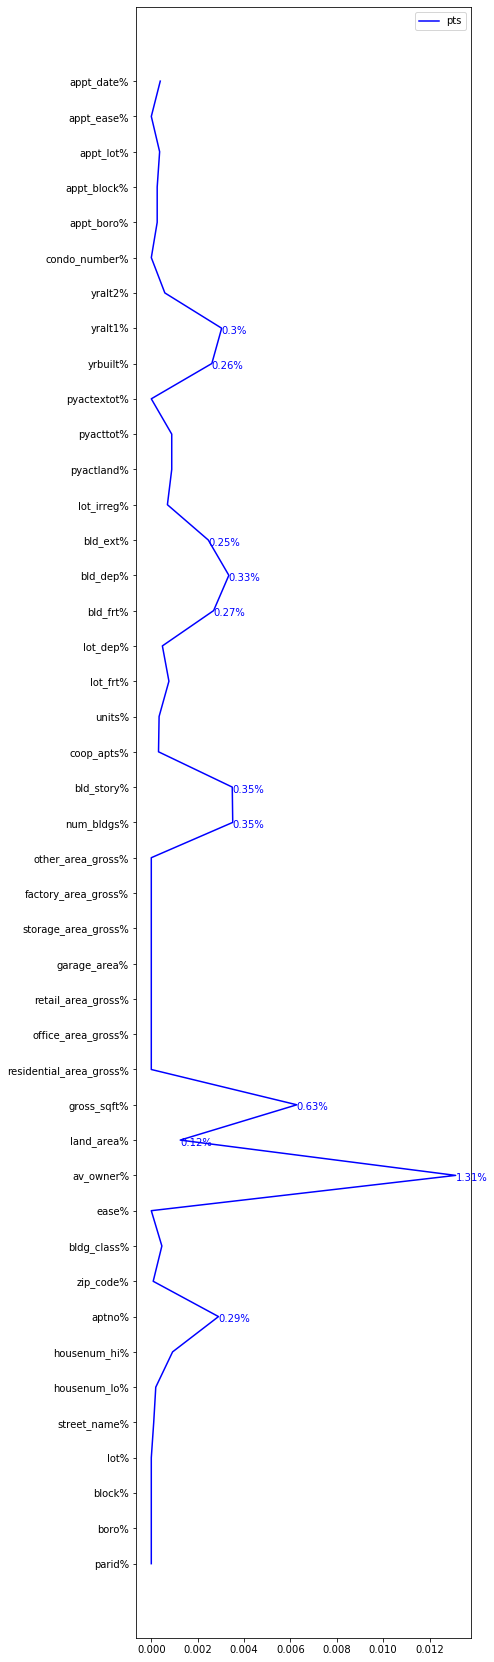

In [37]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.loc[0, cols], range(len(cols)), label = 'pts', color = 'blue')

label = list(results_df.loc[0, cols])

for i in range(len(label)):
    if label[i] >= 0.001:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(len(cols)), cols, rotation='horizontal')
plt.legend()
plt.show()